In [29]:
import torch
from torch import no_grad
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    CrossEntropyLoss
)
import torch.nn.functional as F

from torchvision import datasets, transforms
from torchmetrics.classification import Accuracy
import time

import numpy as np
import matplotlib.pyplot as plt

In [30]:
torch.manual_seed(42)
batch_size = 32

# Train DataLoader
data_root = "./birdsong/"

data_transform = transforms.Compose([
    #transforms.Resize((400, 1000)), 
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

custom_dataset = datasets.ImageFolder(root=data_root, transform=data_transform)
train_dataset = custom_dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Number of training samples:", len(train_dataset))

# Test DataLoader
data_root = "./birdsong_test/" 

data_transform = transforms.Compose([
    #transforms.Resize((400, 1000)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

custom_dataset = datasets.ImageFolder(root=data_root, transform=data_transform)
test_dataset = custom_dataset
test_loader = DataLoader(test_dataset, shuffle=False)

print("Number of test samples:", len(test_dataset))

Number of training samples: 1866
Number of test samples: 464


In [31]:
class CNN(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(3, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.conv3 = Conv2d(16, 64, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(356224, 64)
        self.fc2 = Linear(64, 32)
        self.fc3 = Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))      
        x= self.fc3(x)
        return torch.cat((x, 1 - x), -1)

In [32]:
model = CNN() # Model
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Optimizer 
loss_func = CrossEntropyLoss() # Loss Functions
epochs = 15  # Set number of epochs
loss_list = []  # Store loss history
accuracy_list = []

model.train()  # Set model to training mode

start_time = time.time()

for epoch in range(epochs):
    y_true = []
    y_pred_probs = []
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        print(loss)
        probabilities = F.softmax(output, dim=1)
        y_true.extend(target.tolist())
        y_pred_probs.extend(probabilities.tolist())
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    y_pred_probs = torch.tensor(y_pred_probs)
    y_pred = torch.argmax(y_pred_probs, dim=1)
    accuracy = Accuracy(task="binary")(y_pred, torch.tensor(y_true))
    accuracy_list.append(accuracy.item())
    print("Accuracy:", accuracy.item())
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))
    
end_time = time.time()  # Record end time
training_time = end_time - start_time
print("Total training time: {:.2f} seconds".format(training_time))

tensor(0.6004, grad_fn=<NllLossBackward0>)
tensor(0.7312, grad_fn=<NllLossBackward0>)
tensor(0.6645, grad_fn=<NllLossBackward0>)
tensor(0.7270, grad_fn=<NllLossBackward0>)
tensor(0.6401, grad_fn=<NllLossBackward0>)
tensor(0.6647, grad_fn=<NllLossBackward0>)
tensor(0.7227, grad_fn=<NllLossBackward0>)
tensor(0.7013, grad_fn=<NllLossBackward0>)
tensor(0.5848, grad_fn=<NllLossBackward0>)
tensor(0.7353, grad_fn=<NllLossBackward0>)
tensor(0.6946, grad_fn=<NllLossBackward0>)
tensor(0.7575, grad_fn=<NllLossBackward0>)
tensor(0.6628, grad_fn=<NllLossBackward0>)
tensor(0.7194, grad_fn=<NllLossBackward0>)
tensor(0.7695, grad_fn=<NllLossBackward0>)
tensor(0.6610, grad_fn=<NllLossBackward0>)
tensor(0.7110, grad_fn=<NllLossBackward0>)
tensor(0.7348, grad_fn=<NllLossBackward0>)
tensor(0.6959, grad_fn=<NllLossBackward0>)
tensor(0.6708, grad_fn=<NllLossBackward0>)
tensor(0.6872, grad_fn=<NllLossBackward0>)
tensor(0.6922, grad_fn=<NllLossBackward0>)
tensor(0.7186, grad_fn=<NllLossBackward0>)
tensor(0.69

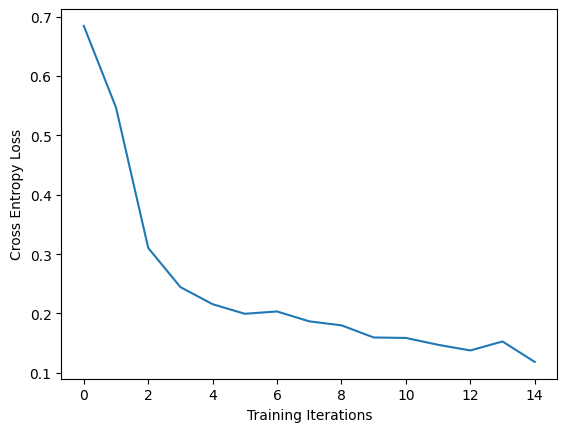

In [42]:
plt.plot(loss_list)
plt.xlabel("Training Iterations")
plt.ylabel("Cross Entropy Loss")
plt.show()

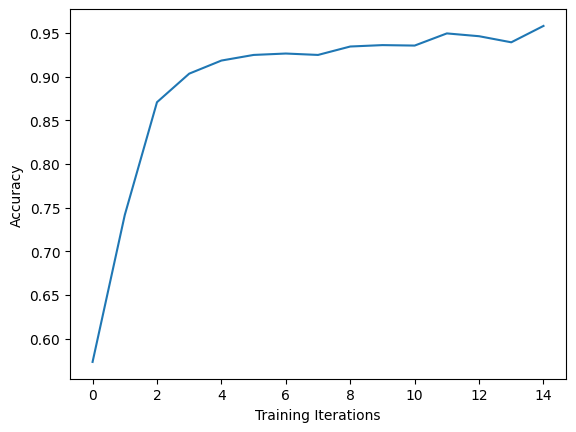

In [43]:
plt.plot(accuracy_list)
plt.xlabel("Training Iterations")
plt.ylabel("Accuracy")
plt.show()

In [44]:
PATH = 'models/birdsong_cnn_classical.pt'
torch.save(model.state_dict(), PATH)

In [45]:
import torch
PATH = 'models/birdsong_cnn_classical.pt'
#model = CNN()u
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [37]:
from torchmetrics.classification import Accuracy, ConfusionMatrix, BinaryF1Score, BinaryPrecision, BinaryRecall, BinaryHingeLoss
model.eval()

CNN(
  (conv1): Conv2d(3, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=356224, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [38]:
y_true = []
y_pred_probs = []

with torch.no_grad():

    for images, labels in test_loader:
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        y_true.extend(labels.tolist())
        y_pred_probs.extend(probabilities.tolist())

y_pred_probs = torch.tensor(y_pred_probs)
y_pred = torch.argmax(y_pred_probs, dim=1)

# Calculate accuracy
accuracy = Accuracy(task="binary")(y_pred, torch.tensor(y_true))
print("Accuracy:", accuracy.item())

# Calculate cross-entropy loss
CELoss = loss_func(outputs, labels)
print("Cross-Entropy Loss:", CELoss.item())

# Calculate confusion matrix
confmat = ConfusionMatrix(task="binary", num_classes=2)
confmat_result = confmat(y_pred, torch.tensor(y_true))
print("Confusion Matrix:")
print(confmat_result.tolist())

# Calculate F1 Score
f1 = BinaryF1Score()
f1_result = f1(y_pred, torch.tensor(y_true))
print("F1 Score:", f1_result.item())

# Calculate Binary Precision
precision = BinaryPrecision()
precision_result = precision(y_pred, torch.tensor(y_true))
print("Binary Precision:", precision_result.item())

# Calculate Binary Recall
recall = BinaryRecall()
recall_result = recall(y_pred, torch.tensor(y_true))
print("Binary Recall:", recall_result.item())

Accuracy: 0.9288793206214905
Cross-Entropy Loss: 0.0005485698929987848
Confusion Matrix:
[[206, 8], [25, 225]]
F1 Score: 0.9316770434379578
Binary Precision: 0.9656652212142944
Binary Recall: 0.8999999761581421


In [39]:
y_true = []
y_pred_probs = []

with torch.no_grad():

    for images, labels in train_loader:
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        y_true.extend(labels.tolist())
        y_pred_probs.extend(probabilities.tolist())

y_pred_probs = torch.tensor(y_pred_probs)
y_pred = torch.argmax(y_pred_probs, dim=1)

# Calculate accuracy
accuracy = Accuracy(task="binary")(y_pred, torch.tensor(y_true))
print("Accuracy:", accuracy.item())

# Calculate cross-entropy loss
CELoss = loss_func(outputs, labels)
print("Cross-Entropy Loss:", CELoss.item())

# Calculate confusion matrix
confmat = ConfusionMatrix(task="binary", num_classes=2)
confmat_result = confmat(y_pred, torch.tensor(y_true))
print("Confusion Matrix:")
print(confmat_result.tolist())

# Calculate F1 Score
f1 = BinaryF1Score()
f1_result = f1(y_pred, torch.tensor(y_true))
print("F1 Score:", f1_result.item())

# Calculate Binary Precision
precision = BinaryPrecision()
precision_result = precision(y_pred, torch.tensor(y_true))
print("Binary Precision:", precision_result.item())

# Calculate Binary Recall
recall = BinaryRecall()
recall_result = recall(y_pred, torch.tensor(y_true))
print("Binary Recall:", recall_result.item())

Accuracy: 0.956055760383606
Cross-Entropy Loss: 0.19658777117729187
Confusion Matrix:
[[837, 23], [59, 947]]
F1 Score: 0.9585019946098328
Binary Precision: 0.9762886762619019
Binary Recall: 0.9413518905639648


In [40]:
print(loss_list)

[0.6845085368318072, 0.5468941214731184, 0.3103574487870022, 0.2444557128316265, 0.21562132706581535, 0.19953008457008053, 0.20342433383151637, 0.1867632718788365, 0.180046167887621, 0.1596094602561098, 0.15881646383490602, 0.14724372554633577, 0.1377289674355317, 0.1528748580080978, 0.1184149282684518]


In [41]:
print(accuracy_list)

[0.5734190940856934, 0.7416934370994568, 0.8708467483520508, 0.9035369753837585, 0.9185423254966736, 0.92497318983078, 0.9265809059143066, 0.92497318983078, 0.9346194863319397, 0.9362272024154663, 0.9356912970542908, 0.9496248364448547, 0.9464094042778015, 0.9394426345825195, 0.9581993818283081]
